In [1]:
!pip install flax

from functools import partial

from tqdm.auto import tqdm

import h5py
import numpy as np

import jax
import jax.numpy as jnp
from flax import linen as nn
from flax.training import train_state
import optax
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt


# Make sure tf does not allocate gpu memory.
tf.config.experimental.set_visible_devices([], "GPU")

# init rng seed
rng = jax.random.PRNGKey(0)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!wget http://astro.utoronto.ca/~bovy/Galaxy10/Galaxy10.h5

--2022-11-17 12:46:23--  http://astro.utoronto.ca/~bovy/Galaxy10/Galaxy10.h5
Resolving astro.utoronto.ca (astro.utoronto.ca)... 128.100.89.2
Connecting to astro.utoronto.ca (astro.utoronto.ca)|128.100.89.2|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 210234548 (200M) [text/plain]
Saving to: ‘Galaxy10.h5.2’

Galaxy10.h5.2       100%[===================>] 200.50M  29.3MB/s    in 8.5s    

2022-11-17 12:46:33 (23.6 MB/s) - ‘Galaxy10.h5.2’ saved [210234548/210234548]



In [3]:
# Get galaxies, ref.: https://astronn.readthedocs.io/en/latest/galaxy10sdss.html
with h5py.File('Galaxy10.h5', 'r') as F:
  labels = np.array(F['ans'])
  # reject some we don't care about, keep the rest
  (milkywaylikes_idx,) = np.where(labels > 3)
  images = np.array(F['images'][milkywaylikes_idx])
  # Milky way similar galaxies are class '3' ('-4' normalizes the labels again)
  labels = np.array(F['ans'][milkywaylikes_idx]) - 4

images = images.astype(np.float32) / 255.

# crop the image a bit to get 64x64 shape
def crop_center(images, cropx, cropy):
    _, y, x, _ = images.shape
    startx = x // 2 -(cropx // 2)
    starty = y // 2 -(cropy // 2)    
    return images[:, starty:starty+cropy, startx:startx+cropx, :]

images = crop_center(images=images, cropx=64, cropy=64)

# shuffle once
rng, key = jax.random.split(rng)
shuffle_idx = jax.random.randint(key, (len(images),), 0, len(images))
images = images[shuffle_idx, ...]
labels = labels[shuffle_idx, ...]

# show shape
print(images.shape)

(4686, 64, 64, 3)


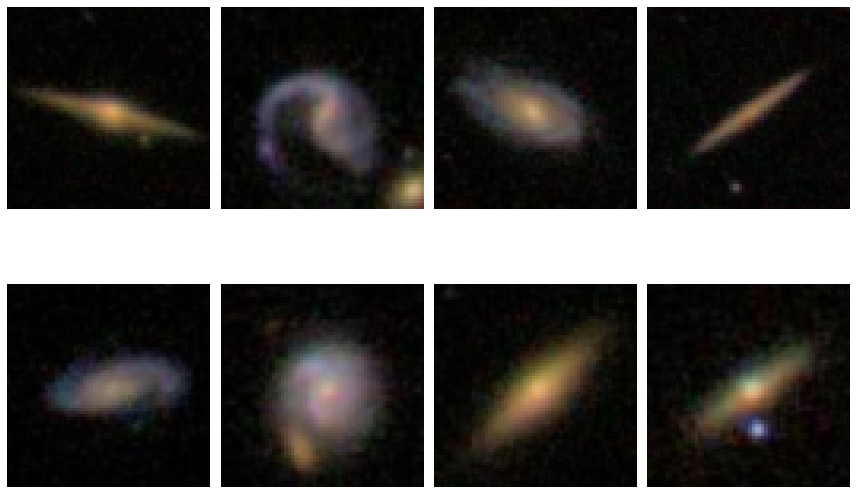

In [4]:
%matplotlib inline

def show_galaxies(images: np.ndarray) -> None:
  n = len(images)
  # always 4 in a column
  ncols = 4
  nrows = -(-n // ncols)
  fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 12))

  for img, ax in zip(images, axes.ravel()):
    ax.imshow(img)
    ax.axis('off')
    fig.tight_layout()

# plot first 8 images
show_galaxies(images[:8])

## Task

Find the galaxy which looks as close as possible to our milky way!

**Bonus**: Generate a new galaxy, which looks as close as possible to our milky way.

#### Milky way

![Milky way](https://solarsystem.nasa.gov/system/resources/detail_files/285_ssc2008-10b1.jpg)

In [5]:
# VAE model
def reparameterize(rng, mean, logvar):
  std = jnp.exp(0.5 * logvar)
  eps = jax.random.normal(rng, logvar.shape)
  return mean + eps * std


class Encoder(nn.Module):
  latents: int

  @nn.compact
  def __call__(self, x):
    # 64x64 => 32x32
    x = nn.Conv(features=16, kernel_size=(3, 3), strides=2)(x)
    x = nn.relu(x)

    # 32x32 => 16x16
    x = nn.Conv(features=32, kernel_size=(3, 3), strides=2)(x)
    x = nn.relu(x)

    # 16x16 => 8x8
    x = nn.Conv(features=64, kernel_size=(3, 3), strides=2)(x)
    x = nn.relu(x)

    # image grid to single feature vector
    x = x.reshape(x.shape[0], -1)

    # latent space
    mean_x = nn.Dense(self.latents)(x)
    logvar_x = nn.Dense(self.latents)(x)
    return mean_x, logvar_x


class Decoder(nn.Module):
  @nn.compact
  def __call__(self, z):
    z = nn.Dense(1024)(z)
    z = nn.relu(z)

    # Dense => 8x8
    z = z.reshape(z.shape[0], 8, 8, -1)

    # 8x8 => 16x16
    z = nn.ConvTranspose(features=64, kernel_size=(3, 3), strides=(2, 2))(z)
    z = nn.relu(z)

    # 16x16 => 32x32
    z = nn.ConvTranspose(features=32, kernel_size=(3, 3), strides=(2, 2))(z)
    z = nn.relu(z)

    # 32x32 => 64x64 (output size must have dimension of original image)
    z = nn.ConvTranspose(features=16, kernel_size=(3, 3), strides=(2, 2))(z)
    z = nn.relu(z)

    # 16 features => 3 colors
    z = nn.ConvTranspose(features=3, kernel_size=(1, 1))(z)
    return z


class VAE(nn.Module):
  latents: int = 64

  def setup(self):
    self.encoder = Encoder(self.latents)
    self.decoder = Decoder()

  def __call__(self, x, z_rng):
    mean, logvar = self.encoder(x)
    z = reparameterize(z_rng, mean, logvar)
    recon_x = self.decoder(z)
    return recon_x, mean, logvar

  def generate(self, z):
    return nn.sigmoid(self.decoder(z))


In [6]:
# Losses
@jax.vmap
def kl_divergence(mean, logvar):
  return -0.5 * jnp.sum(1 + logvar - jnp.square(mean) - jnp.exp(logvar))


@jax.vmap
def binary_cross_entropy_with_logits(logits, labels):
  logits = nn.log_sigmoid(logits)
  return -jnp.sum(labels * logits + (1. - labels) * jnp.log(-jnp.expm1(logits)))
  

def compute_metrics(recon_x, x, mean, logvar):
  bce_loss = binary_cross_entropy_with_logits(recon_x, x).mean()
  kld_loss = kl_divergence(mean, logvar).mean()
  return {
      "bce": bce_loss,
      "kld": kld_loss,
      "loss": bce_loss + kld_loss
  }

In [7]:
learning_rate = 5e-4
epochs = 300
latents = 150
batch_size = 32

# init model
model = VAE(latents)


# use 4500 for training, rest for testing
split = 4500
train_idx, test_idx = slice(0, split), slice(split, -1)

# train
train_images = jnp.asarray(images[train_idx])
n_train_images = len(train_images)

# test
test_images = jnp.asarray(images[test_idx])

In [8]:
# define train state
rng, key = jax.random.split(rng)
init_data = jnp.ones((batch_size, *train_images.shape[1:]), jnp.float32)

state = train_state.TrainState.create(
  apply_fn=model.apply,
  params=model.init(key, init_data, rng)['params'],
  tx=optax.adam(learning_rate),
)


# extract metrics
@jax.jit
def evaluate(params, images, z_rng):
  def evaluate_fn(model):
    recon_images, mean, logvar = model(images, z_rng)
    metrics = compute_metrics(recon_images, images, mean, logvar)
    return metrics
  return nn.apply(evaluate_fn, model)({'params': params})


# one train step
@jax.jit
def train_step(state, batch, z_rng):
  def loss_fn(params):
    recon_x, mean, logvar = model.apply({'params': params}, batch, z_rng)
    bce_loss = binary_cross_entropy_with_logits(recon_x, batch).mean()
    kld_loss = kl_divergence(mean, logvar).mean()
    loss = bce_loss + kld_loss
    return loss

  # calculate gradient & apply
  grads = jax.grad(loss_fn)(state.params)
  return state.apply_gradients(grads=grads)


# training loop
steps_per_epoch = n_train_images // batch_size
for epoch in tqdm(range(epochs), unit="epoch"):
  perms = jax.random.permutation(rng, n_train_images)
  # skip incomplete batch
  perms = perms[:steps_per_epoch * batch_size]
  perms = perms.reshape((steps_per_epoch, batch_size))

  for perm in perms:
    batch = train_images[perm, ...]
    state = train_step(state, batch, key)
    rng, key = jax.random.split(rng)
  
  metrics = evaluate(state.params, test_images, rng)

  tqdm.write("epoch: {} - loss: {:.4f} - BCE: {:.4f} - KLD: {:.4f}".format(
      epoch + 1, metrics['loss'], metrics['bce'], metrics['kld']
  ))

  0%|          | 0/300 [00:00<?, ?epoch/s]

epoch: 1 - loss: 2973.4583 - BCE: 2924.2595 - KLD: 49.1988
epoch: 2 - loss: 2924.7483 - BCE: 2873.6460 - KLD: 51.1023
epoch: 3 - loss: 2890.7705 - BCE: 2844.3784 - KLD: 46.3922
epoch: 4 - loss: 2874.9807 - BCE: 2829.1057 - KLD: 45.8750
epoch: 5 - loss: 2872.7131 - BCE: 2820.6555 - KLD: 52.0575
epoch: 6 - loss: 2868.5403 - BCE: 2818.1643 - KLD: 50.3760
epoch: 7 - loss: 2852.3103 - BCE: 2805.6309 - KLD: 46.6795
epoch: 8 - loss: 2853.0693 - BCE: 2805.4277 - KLD: 47.6415
epoch: 9 - loss: 2843.6292 - BCE: 2797.7871 - KLD: 45.8421
epoch: 10 - loss: 2838.3755 - BCE: 2792.3279 - KLD: 46.0477
epoch: 11 - loss: 2834.8713 - BCE: 2790.2773 - KLD: 44.5940
epoch: 12 - loss: 2826.3142 - BCE: 2783.8298 - KLD: 42.4844
epoch: 13 - loss: 2821.1992 - BCE: 2780.2324 - KLD: 40.9668
epoch: 14 - loss: 2818.9045 - BCE: 2778.5696 - KLD: 40.3351
epoch: 15 - loss: 2812.0491 - BCE: 2772.9985 - KLD: 39.0506
epoch: 16 - loss: 2813.2825 - BCE: 2774.2944 - KLD: 38.9881
epoch: 17 - loss: 2806.7766 - BCE: 2770.0549 - KL

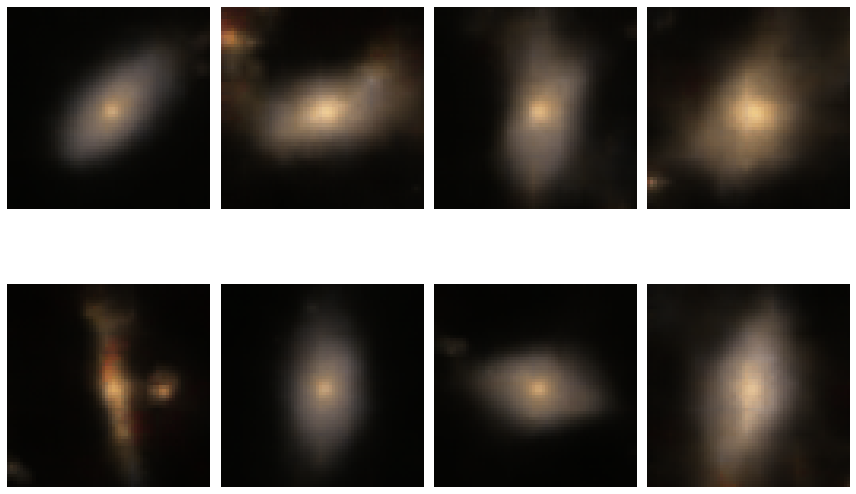

In [9]:
%matplotlib inline

from copy import deepcopy

# save state for later
vae_state = deepcopy(state)
del state

# prepare random latents for 8 galaxies
rng, z_key = jax.random.split(rng)
z = jax.random.normal(z_key, (8, latents))

# generate images
def gen(model):
  return model.generate(z)


generated_images = nn.apply(gen, model)({"params": vae_state.params})
show_galaxies(generated_images)

In [10]:
# We have generated new galaxies!
# Now, we need to find one, which looks as close as possible to our milky way.
# Milky way similar galaxies correspond to label == 7: 'Disk, Face-on, Tight Spiral'.
# see: https://astronn.readthedocs.io/en/latest/galaxy10sdss.html


class CNN(nn.Module):
  n_classes: int

  @nn.compact
  def __call__(self, x):
    # 64x64x3 => # 64x64x<features>
    x = nn.Conv(features=16, kernel_size=(3, 3))(x)
    x = nn.relu(x)

    # 64x64 => 32x32
    x = nn.max_pool(x, window_shape=(2, 2), strides=(2, 2))
    x = nn.Conv(features=32, kernel_size=(3, 3))(x)
    x = nn.relu(x)
    
    # 32x32 => 16x16
    x = nn.max_pool(x, window_shape=(2, 2), strides=(2, 2))
    x = nn.Conv(features=64, kernel_size=(3, 3))(x)
    x = nn.relu(x)
    
    # 16x16 => 8x8
    x = nn.max_pool(x, window_shape=(2, 2), strides=(2, 2))
    
    # flatten for Dense layer
    x = x.reshape((x.shape[0], -1))
    x = nn.Dense(features=512)(x)
    x = nn.relu(x)
    x = nn.Dropout(0.5, deterministic=True)(x)
    x = nn.Dense(features=self.n_classes)(x)
    return x

In [11]:
# init training parameters and model

learning_rate = 1e-4
epochs = 30
batch_size = 32

n_classes = len(jnp.unique(labels))
classifier = CNN(n_classes=n_classes)


# reuse images from previous cell
# train labels
train_labels = jnp.asarray(labels[train_idx])

# test labels
test_labels = jnp.asarray(labels[test_idx])


# class weights, because dataset is unbalanced
@jax.vmap
def weight(label: int) -> float:
  return jnp.sum(train_labels == label) / len(train_labels)

class_weights = 1 / weight(jnp.array([0, 1, 2, 3, 4 ,5]))
# norm by min value
class_weights = class_weights / jnp.max(class_weights)
print(class_weights)

[0.01140174 1.         0.03113553 0.01513802 0.02063107 0.03406814]


In [12]:
# define train state
rng, key = jax.random.split(rng)
init_data = jnp.ones((batch_size, *train_images.shape[1:]), jnp.float32)

state = train_state.TrainState.create(
  apply_fn=classifier.apply,
  params=classifier.init(key, init_data)["params"],
  tx=optax.adam(learning_rate),
)


# loss function
@jax.jit
def cross_entropy(logits, labels):
  """weighted cross-entropy"""
  one_hot = jax.nn.one_hot(labels, n_classes)
  loss = jnp.mean(optax.softmax_cross_entropy(logits=logits, labels=one_hot))
  return loss


def compute_metrics(logits, labels):
  loss = cross_entropy(logits, labels)
  accuracy = jnp.mean(jnp.argmax(logits, -1) == labels)
  return {
      "loss": loss,
      "accuracy": accuracy,
  }


@jax.jit
def train_step(state, images, labels):
  def loss_fn(params):
    logits = state.apply_fn({"params": params}, images)
    loss = cross_entropy(logits, labels)
    
    # add L2 norm
    def l2_loss(x, alpha):
      return alpha * (x ** 2).mean()

    loss += sum(
      l2_loss(w, alpha=0.001) 
      for w in jax.tree_util.tree_leaves(params)
    )
    return loss

  # calculate gradient and apply
  grads = jax.grad(loss_fn)(state.params)
  return state.apply_gradients(grads=grads)


# extract metrics
@jax.jit
def evaluate(params, images, labels):
  def evaluate_fn(model):
    logits = state.apply_fn({"params": params}, images)
    metrics = compute_metrics(logits, labels)
    return metrics
  return nn.apply(evaluate_fn, model)({"params": params})


# training loop
steps_per_epoch = n_train_images // batch_size
for epoch in tqdm(range(epochs), unit="epoch"):
  rng, key = jax.random.split(rng)
  perms = jax.random.permutation(rng, n_train_images)
  # skip incomplete batch
  perms = perms[:steps_per_epoch * batch_size]
  perms = perms.reshape((steps_per_epoch, batch_size))

  for perm in perms:
    images_batch = train_images[perm, ...]
    labels_batch = train_labels[perm, ...]
    state = train_step(state, images_batch, labels_batch)

  metrics = evaluate(state.params, test_images, test_labels)

  tqdm.write("epoch: {} - loss: {:.4f} - acc: {:.4f}".format(
      epoch + 1, metrics["loss"], metrics["accuracy"]
  ))


  0%|          | 0/30 [00:00<?, ?epoch/s]

epoch: 1 - loss: 0.9482 - acc: 0.6162
epoch: 2 - loss: 0.7778 - acc: 0.6378
epoch: 3 - loss: 0.7556 - acc: 0.6757
epoch: 4 - loss: 0.7438 - acc: 0.6649
epoch: 5 - loss: 0.6692 - acc: 0.6865
epoch: 6 - loss: 0.6658 - acc: 0.7459
epoch: 7 - loss: 0.6558 - acc: 0.7081
epoch: 8 - loss: 0.6296 - acc: 0.7405
epoch: 9 - loss: 0.6516 - acc: 0.7351
epoch: 10 - loss: 0.6309 - acc: 0.7784
epoch: 11 - loss: 0.5677 - acc: 0.7784
epoch: 12 - loss: 0.6595 - acc: 0.7081
epoch: 13 - loss: 0.5792 - acc: 0.7892
epoch: 14 - loss: 0.5639 - acc: 0.7838
epoch: 15 - loss: 0.5654 - acc: 0.7784
epoch: 16 - loss: 0.5962 - acc: 0.7838
epoch: 17 - loss: 0.6254 - acc: 0.7514
epoch: 18 - loss: 0.6187 - acc: 0.7514
epoch: 19 - loss: 0.5509 - acc: 0.7838
epoch: 20 - loss: 0.5166 - acc: 0.7892
epoch: 21 - loss: 0.5386 - acc: 0.7892
epoch: 22 - loss: 0.5309 - acc: 0.8108
epoch: 23 - loss: 0.5323 - acc: 0.7838
epoch: 24 - loss: 0.5200 - acc: 0.8054
epoch: 25 - loss: 0.5356 - acc: 0.8054
epoch: 26 - loss: 0.6192 - acc: 0.

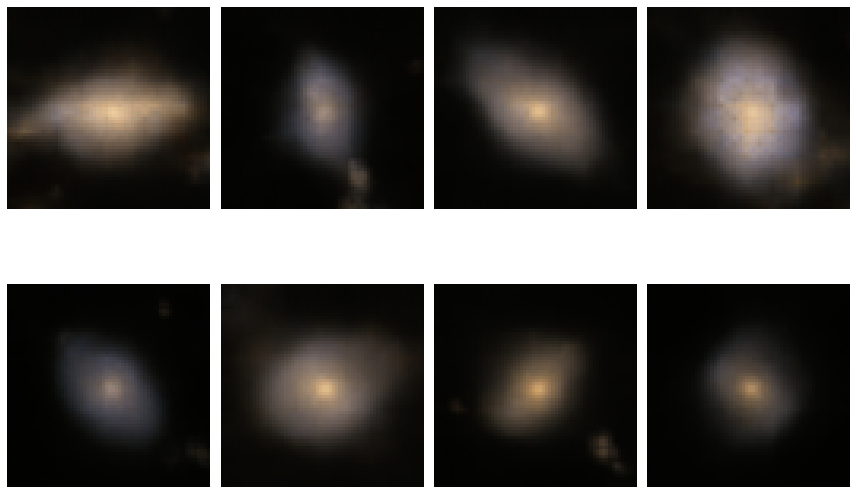

In [13]:
%matplotlib inline

# evaluate on generated images to find the one which has the highest output for class '7'

# prepare random latents for 50 galaxies
rng, z_key = jax.random.split(rng)
z = jax.random.normal(z_key, (50, latents))

# generate images
def gen(model):
  return model.generate(z)


generated_images = nn.apply(gen, model)({"params": vae_state.params})

# extract the top 4 candidates for class '7' (most milky way likes)
@jax.jit
def milkyway_candidates(params, images):
  def milkyways_fn(model):
    logits = state.apply_fn({'params': params}, images)
    milkyway_candidates = jnp.argmax(logits, -1) == 3
    # sort by best prediction
    order = jnp.argsort(jnp.where(milkyway_candidates, jnp.max(nn.softmax(logits), axis=-1), 0))
    return milkyway_candidates, order
  return nn.apply(milkyways_fn, model)({'params': params})

candidates, order = milkyway_candidates(state.params, generated_images)

# order them by max output prediction, then filter only the candidates
milkyways = generated_images[candidates][order]
show_galaxies(milkyways[:8])